In [1]:
import sys
import numpy as np
import pandas as pd
from scipy.misc import imread 
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

In [2]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 105kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


## The data has been divided into two sets, training and testing . In the testing folder 3 images from each celeb category has been taken from main dataset.


In [2]:
!unzip '/content/img_align_celeba_eval.zip' -d ./
!unzip '/content/img_align_celeba_train.zipno' -d ./


Archive:  /content/img_align_celeba_eval.zip
replace ./img_align_celeba_eval/3782/176864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/img_align_celeba_train.zip
replace ./img_align_celeba_train/3782/173996.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
def loadimgs(path,n = 0):
  
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    # we load every Celeb seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        category=[]
        # every image/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
           
           
            letter_path = os.path.join(alphabet_path, letter)
            image = imread(letter_path)
            # category_images.append(image)
            category.append(image)
            y.append(curr_y)
            # read all the images in the current category
            
        curr_y += 1
        X.append(np.stack(category))
            # lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y

In [8]:
# Loading Training Data
Xtrain,ytrain=loadimgs('/content/img_align_celeba_train')

loading alphabet: 2820
loading alphabet: 6568
loading alphabet: 3782
loading alphabet: 2114
loading alphabet: 3227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [9]:
# Loading Testing Data
Xtest,ytest=loadimgs('/content/img_align_celeba_eval')

loading alphabet: 2820
loading alphabet: 6568
loading alphabet: 3782
loading alphabet: 2114
loading alphabet: 3227


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


In [6]:
Xtrain=Xtrain/255;
Xtest=Xtest/255

In [10]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [11]:
model = get_siamese_model((218, 178, 3))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         315784512   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

In [12]:
# Model Compilationa and adding Adam optimizer
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [13]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain

    else:
        X = Xtest
  
    n_classes, n_examples, w, h,z = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, w, h,3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,3)
    
    return pairs, targets

In [14]:
# Generate batches of data for model training
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [15]:
# Create pair of images with diffrent classes
def make_oneshot_task(N, s="val", language=None):
  
    if s == 'train':
        X = Xtrain
    else:
        X = Xtest
    n_classes, n_examples, w, h,z = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,3)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [16]:
from matplotlib import pyplot
# Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks
def test_oneshot(model, N, k, s = "val", verbose = 0,showimage=False):
 
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if showimage:
          # Display images with the predictions and Actual Result
          pyplot.imshow(inputs[0][0])
          pyplot.show()
          print('actual class-',np.argmax(targets))
          print('Predicted class-',np.argmax(probs))

        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [24]:
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 3
n_iter = 10000 # No. of training iterations
N_way = 5 # how many classes for testing one-shot tasks
n_val = 50 # how many one-shot tasks to validate on
best = -1

In [18]:
model_path = 'content/'

In [25]:

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
    
        if val_acc >= best:
            model.save_weights('model.h5')
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 100 iterations: 0.3302171627680461 mins
Train Loss: 0.6764357686042786
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 32.0% 5 way one-shot learning accuracy 

Current best: 32.0, previous best: -1

 ------------- 

Time for 200 iterations: 0.7870969176292419 mins
Train Loss: 0.6768329739570618
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 22.0% 5 way one-shot learning accuracy 


 ------------- 

Time for 300 iterations: 1.1598096211751303 mins
Train Loss: 0.6755360960960388
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 16.0% 5 way one-shot learning accuracy 


 ------------- 

Time for 400 iterations: 1.532948919137319 mins
Train Loss: 0.6726624369621277
Evaluating model on 50 random 5 way one-shot learning tasks ... 

Got an average of 36.0% 5 way one-shot learning accuracy 

Curren

In [26]:
model.load_weights("model.h5")

Evaluating model on 50 random 5 way one-shot learning tasks ... 



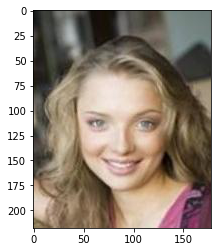

actual class- 2
Predicted class- 1


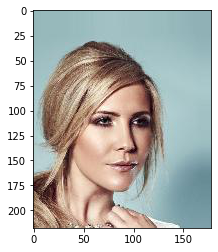

actual class- 3
Predicted class- 0


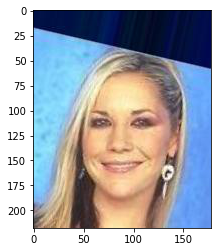

actual class- 0
Predicted class- 3


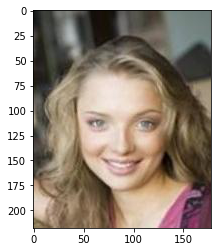

actual class- 0
Predicted class- 0


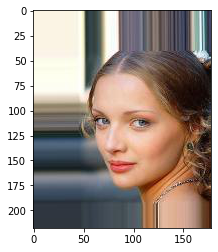

actual class- 2
Predicted class- 2


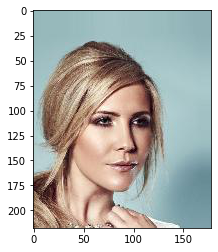

actual class- 2
Predicted class- 2


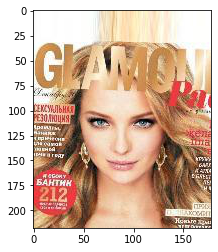

actual class- 1
Predicted class- 1


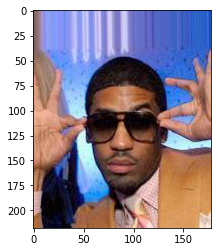

actual class- 0
Predicted class- 0


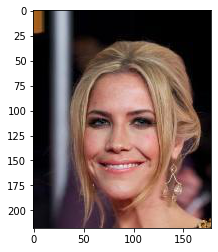

actual class- 3
Predicted class- 3


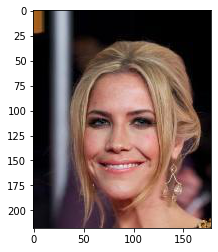

actual class- 0
Predicted class- 0


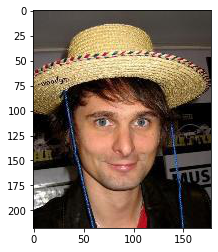

actual class- 1
Predicted class- 0


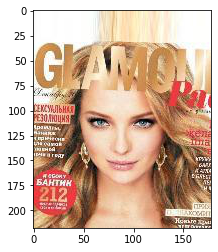

actual class- 2
Predicted class- 0


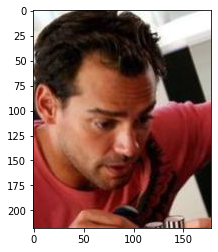

actual class- 1
Predicted class- 3


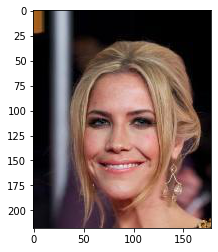

actual class- 2
Predicted class- 0


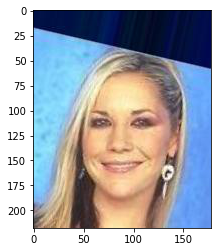

actual class- 2
Predicted class- 2


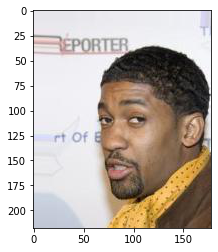

actual class- 4
Predicted class- 0


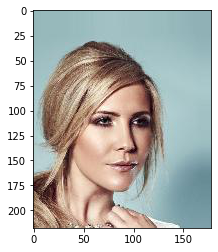

actual class- 4
Predicted class- 1


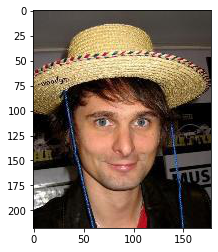

actual class- 1
Predicted class- 0


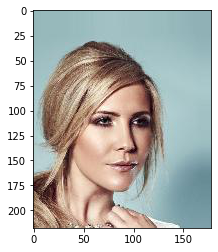

actual class- 4
Predicted class- 3


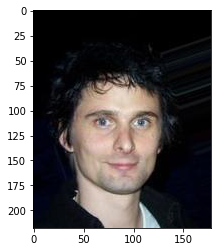

actual class- 3
Predicted class- 0


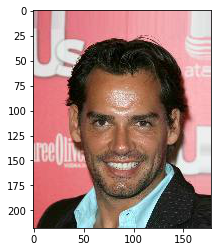

actual class- 0
Predicted class- 0


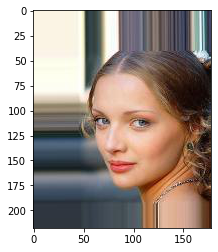

actual class- 2
Predicted class- 2


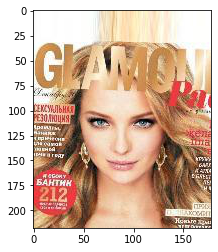

actual class- 0
Predicted class- 0


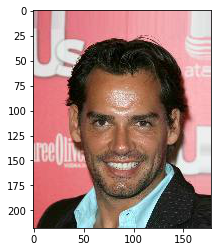

actual class- 2
Predicted class- 0


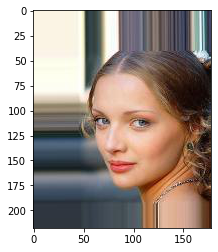

actual class- 1
Predicted class- 1


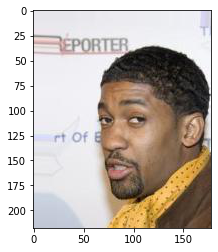

actual class- 0
Predicted class- 2


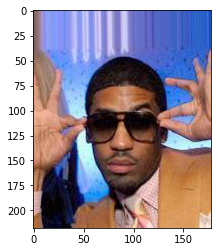

actual class- 3
Predicted class- 3


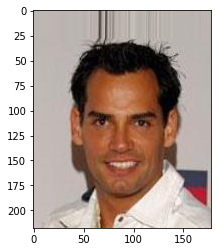

actual class- 4
Predicted class- 4


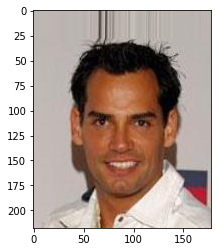

actual class- 3
Predicted class- 1


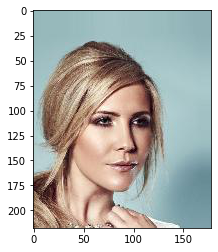

actual class- 3
Predicted class- 3


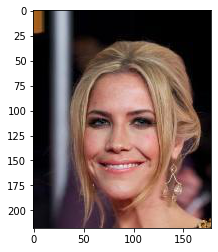

actual class- 4
Predicted class- 2


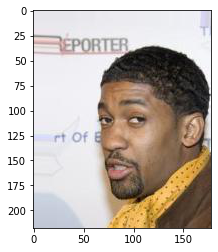

actual class- 0
Predicted class- 1


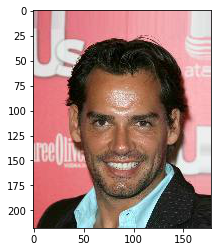

actual class- 0
Predicted class- 0


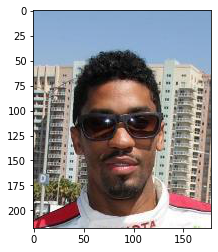

actual class- 0
Predicted class- 3


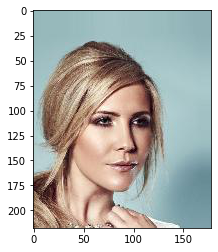

actual class- 2
Predicted class- 1


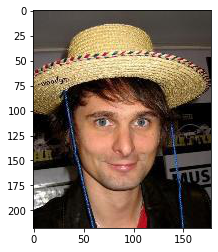

actual class- 4
Predicted class- 0


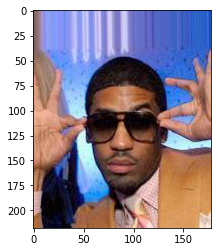

actual class- 4
Predicted class- 4


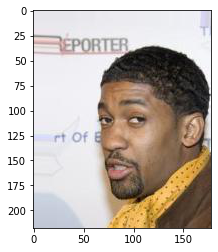

actual class- 1
Predicted class- 2


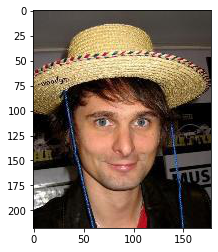

actual class- 4
Predicted class- 2


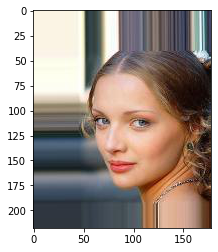

actual class- 4
Predicted class- 0


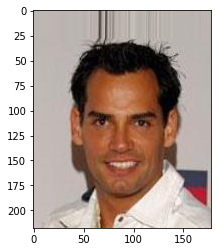

actual class- 3
Predicted class- 4


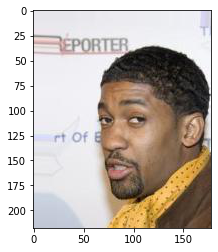

actual class- 3
Predicted class- 0


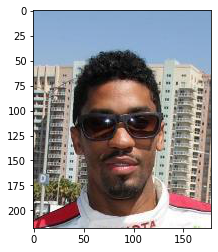

actual class- 3
Predicted class- 0


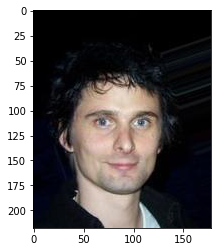

actual class- 2
Predicted class- 0


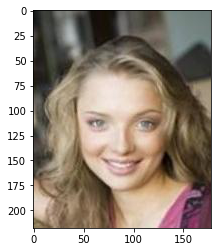

actual class- 1
Predicted class- 1


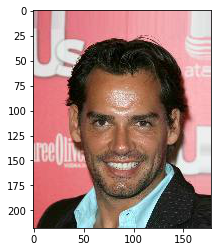

actual class- 4
Predicted class- 4


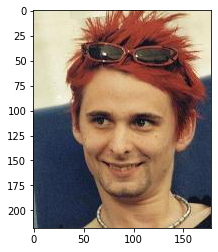

actual class- 1
Predicted class- 2


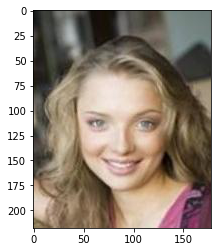

actual class- 1
Predicted class- 1


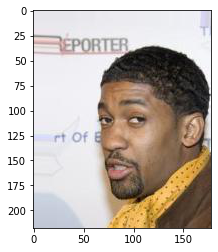

actual class- 4
Predicted class- 0


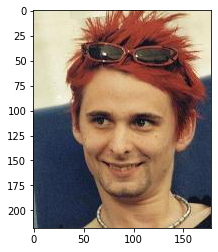

actual class- 1
Predicted class- 0
Got an average of 40.0% 5 way one-shot learning accuracy 



40.0

In [27]:
test_oneshot(model, N_way, n_val, verbose=True,showimage=True)

One Shot Learning with Siamese Networks using Keras has been implemented with the applied on the training data and evaluated the score on the evalaution Data. The model is able to identify correct classes for few examples.